In [75]:
# Impoting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.api import SimpleExpSmoothing
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import boxcox
from scipy.special import inv_boxcox


In [76]:
df = pd.read_excel("LUMAX_Data.xlsx", sheet_name='SKU1')
df = df.set_index('Date of Invoice').sort_index()

# Check for missing dates
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
missing_dates = full_range.difference(df.index)

print(f"Missing Dates: {len(missing_dates)} found.")
if len(missing_dates) > 0:
    print(missing_dates[:10])  # show only first 10 missing dates

# Check datetime spacing
date_diff_counts = df.index.to_series().diff().dropna().value_counts()
print("\nDate Differences:")
print(date_diff_counts)

if len(date_diff_counts) > 1 or date_diff_counts.index[0] != pd.Timedelta(days=1):
    print("Data is not uniformly spaced by 1 day. Use `method='time'` for interpolation.")
else:
    print("Data is uniformly spaced by 1 day. Use `method='linear'` for interpolation.")

# Check for outliers in QTY using IQR
Q1 = df['QTY '].quantile(0.25)
Q3 = df['QTY '].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['QTY '] < Q1 - 1.5 * IQR) | (df['QTY '] > Q3 + 1.5 * IQR)]

print(f"\nOutliers in QTY: {len(outliers)} found.")
if len(outliers) > 0:
    print("Use median or rolling median to fill missing values for QTY.")
else:
    print("QTY data looks clean. You can use interpolation safely.")

# Recommended cleaning strategy
print("\nRecommended Filling Strategy:")
if len(outliers) > 0:
    qty_method = "median or rolling median"
else:
    qty_method = "interpolate(method='time')" if len(date_diff_counts) > 1 else "interpolate(method='linear')"

print(f"For QTY: {qty_method}")
print("For Material No. and other static columns: use .ffill() or .bfill()")

# Optional: Reindex and show what missing rows look like
df_reindexed = df.reindex(full_range)
print("\nReindexed Data Preview (with NaNs):")
print(df_reindexed.head(10))


Missing Dates: 297 found.
DatetimeIndex(['2022-05-23', '2022-05-24', '2022-05-25', '2022-05-27',
               '2022-05-28', '2022-05-29', '2022-05-30', '2022-06-01',
               '2022-06-02', '2022-06-03'],
              dtype='datetime64[ns]', freq=None)

Date Differences:
Date of Invoice
1 days     106
2 days      32
3 days      18
5 days      18
4 days       9
6 days       5
7 days       3
8 days       3
12 days      2
10 days      2
9 days       2
11 days      1
Name: count, dtype: int64
Data is not uniformly spaced by 1 day. Use `method='time'` for interpolation.

Outliers in QTY: 18 found.
Use median or rolling median to fill missing values for QTY.

Recommended Filling Strategy:
For QTY: median or rolling median
For Material No. and other static columns: use .ffill() or .bfill()

Reindexed Data Preview (with NaNs):
            Material No. Cat-III Desc      Cat-IV Desc     QTY   NET SALES
2022-05-20    61004154.0      2W BULB  2W HALOGEN BULB   7200.0  256372.70
2022-05-21 

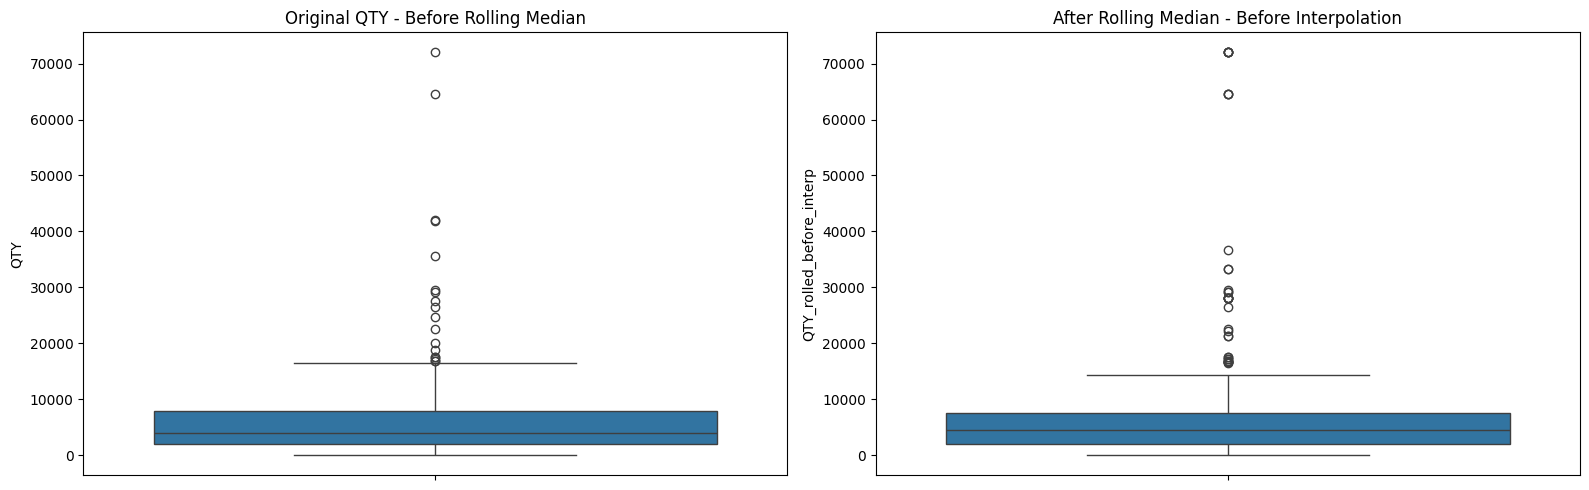

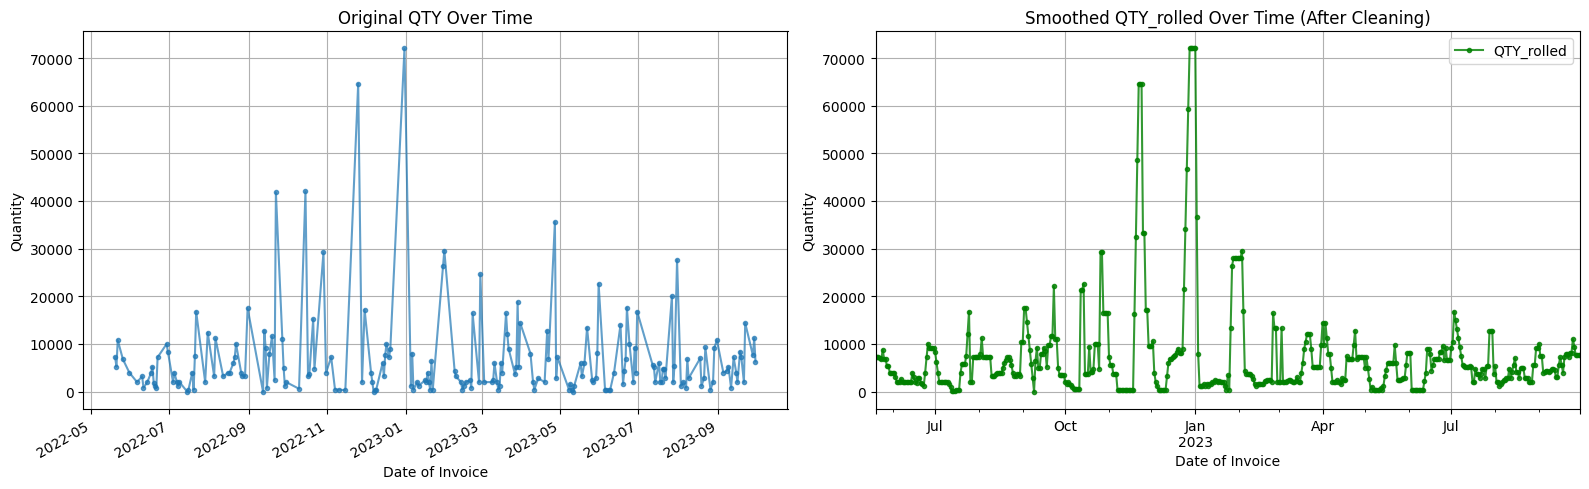

  Date of Invoice  Material No.      QTY  QTY_rolled_before_interp  QTY_rolled
0      2022-05-20      61004154   7200.0                    7200.0        7200
1      2022-05-21      61004154   5200.0                    7200.0        7200
2      2022-05-22      61004154  10800.0                    7200.0        7200
3      2022-05-23      61004154      NaN                    7000.0        7000
4      2022-05-24      61004154      NaN                    6800.0        6800
5      2022-05-25      61004154      NaN                    8800.0        8800
6      2022-05-26      61004154   6800.0                    6800.0        6800
7      2022-05-27      61004154      NaN                    6800.0        6800
8      2022-05-28      61004154      NaN                    5400.0        5400
9      2022-05-29      61004154      NaN                    5400.0        5400
    Date of Invoice  Material No.      QTY  QTY_rolled_before_interp  \
489      2023-09-21      61004154   2000.0                 

In [77]:
# Load the SKU1 sheet
df = pd.read_excel("LUMAX_Data.xlsx", sheet_name='SKU1')

# Fix column names if needed
df.columns = df.columns.str.strip()

# Convert date column to datetime
df['Date of Invoice'] = pd.to_datetime(df['Date of Invoice'])
# Set 'Date of Invoice' as index
df.set_index('Date of Invoice', inplace=True)
# Create complete date range
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Reindex to full dates
df_full = df.reindex(full_index)

# Apply rolling median
df_full['QTY_rolled_before_interp'] = df_full['QTY'].rolling(window=7, center=True, min_periods=1).median()

# --- Plotting boxplots (before interpolation) ---
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Boxplot: Original
sns.boxplot(y=df['QTY'], ax=axes[0])
axes[0].set_title('Original QTY - Before Rolling Median')

# Boxplot: After Rolling Median (before interpolation)
sns.boxplot(y=df_full['QTY_rolled_before_interp'], ax=axes[1])
axes[1].set_title('After Rolling Median - Before Interpolation')

plt.tight_layout()
plt.show()

# --- Now apply interpolation ---

# Interpolate missing values
df_full['QTY_rolled'] = df_full['QTY_rolled_before_interp'].interpolate(method='time').round().astype('Int64')

# Forward-fill other columns
df_full['Material No.'] = df_full['Material No.'].ffill().astype('Int64')

# Reset index
df_full = df_full.reset_index().rename(columns={'index': 'Date of Invoice'})

# Drop unnecessary columns if needed
df_cleaned = df_full.drop(columns=['Cat-III Desc', 'Cat-IV Desc', 'NET SALES'], errors='ignore')

# --- Plotting time series (side-by-side like boxplots) ---
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Time series: Original
df['QTY'].plot(ax=axes[0], style='.-', alpha=0.7)
axes[0].set_title('Original QTY Over Time')
axes[0].set_ylabel('Quantity')
axes[0].set_xlabel('Date of Invoice')
axes[0].grid()

# Time series: After cleaning (rolling median + interpolation)
df_cleaned.plot(x='Date of Invoice', y='QTY_rolled', ax=axes[1], style='.-', alpha=0.8, color='green')
axes[1].set_title('Smoothed QTY_rolled Over Time (After Cleaning)')
axes[1].set_ylabel('Quantity')
axes[1].set_xlabel('Date of Invoice')
axes[1].grid()

plt.tight_layout()
plt.show()

# --- Final cleaned preview ---

print(df_cleaned.head(10))
print(df_cleaned.tail(10))


In [78]:
# Resample to weekly data by summing up 'QTY'
df_weekly = df_cleaned.resample('W-Mon', on='Date of Invoice').sum()['QTY_rolled'].reset_index()

# Check the aggregated weekly data
print(df_weekly.head())
print(df_weekly.tail())

  Date of Invoice  QTY_rolled
0      2022-05-23       28600
1      2022-05-30       44000
2      2022-06-06       21000
3      2022-06-13       14600
4      2022-06-20       18600
   Date of Invoice  QTY_rolled
67      2023-09-04       52796
68      2023-09-11       31198
69      2023-09-18       32995
70      2023-09-25       57384
71      2023-10-02       39800


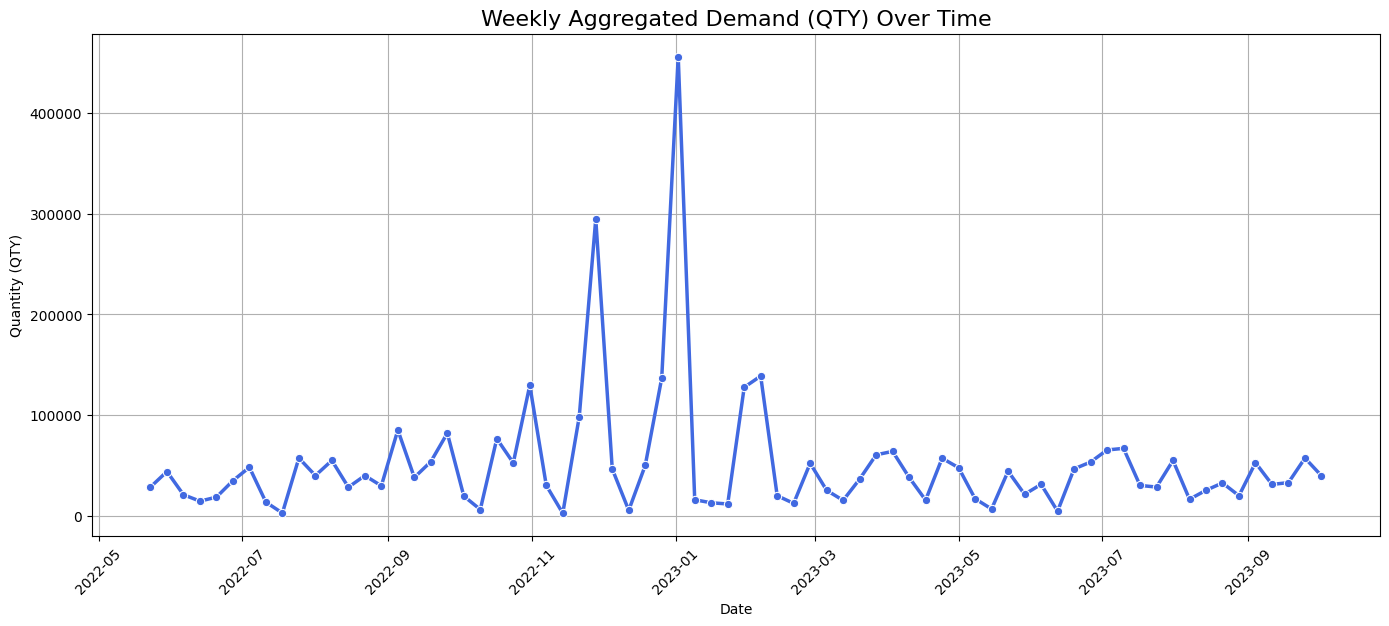

In [79]:
# Plotting graph to see trend and seasonality
# Make sure 'Date of Invoice' is datetime and sorted
df_weekly = df_weekly.sort_values('Date of Invoice')
df_weekly['Date of Invoice'] = pd.to_datetime(df_weekly['Date of Invoice'])

# Plotting
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date of Invoice', y='QTY_rolled', data=df_weekly, marker='o', linewidth=2.5, color='royalblue')
plt.title('Weekly Aggregated Demand (QTY) Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Quantity (QTY)')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


Plotting graph of BoxCox & Log Transformation as Multiplicative Seasonality is present

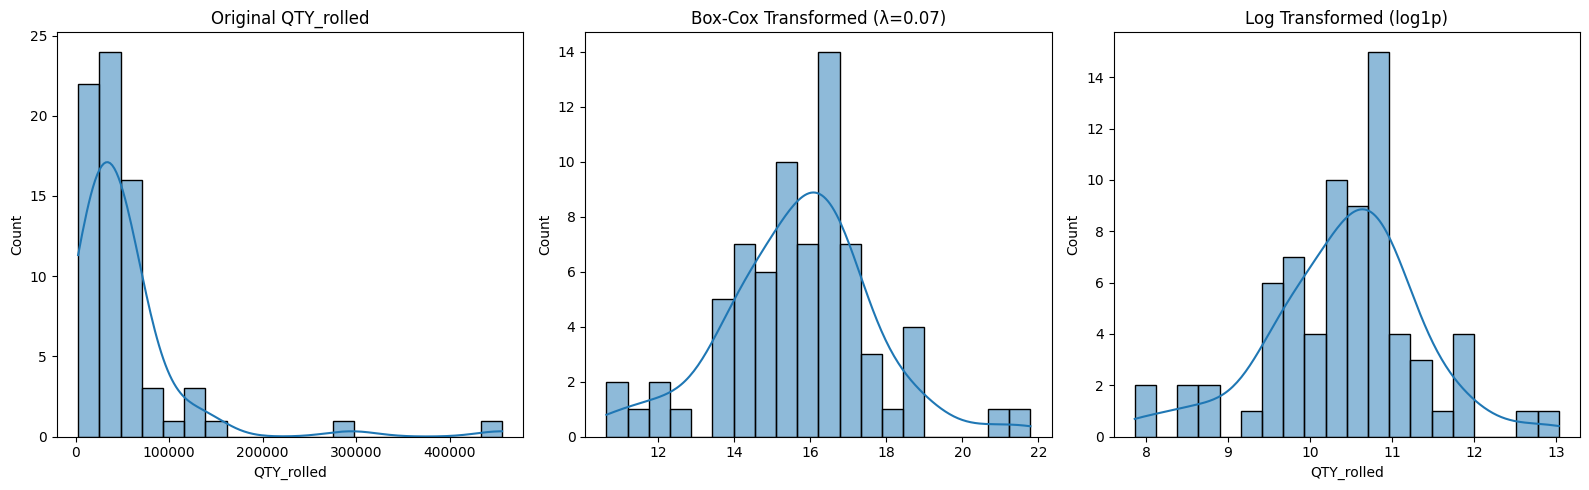

In [80]:
# Drop NaNs and non-positive values
qty = df_weekly['QTY_rolled'].dropna()
qty = qty[qty > 0]

# Box-Cox transformation
qty_boxcox, lmbda = boxcox(qty)
# Store the transformed series in your DataFrame
df_weekly['QTY_boxcox'] = qty_boxcox

# Log transformation (optional)
qty_log = np.log1p(qty)  # log1p handles zero values safely
df_weekly['QTY_log'] = qty_log

# Plotting
plt.figure(figsize=(16, 5))

# Original
plt.subplot(1, 3, 1)
sns.histplot(qty, kde=True, bins=20)
plt.title("Original QTY_rolled")

# Box-Cox
plt.subplot(1, 3, 2)
sns.histplot(qty_boxcox, kde=True, bins=20)
plt.title(f"Box-Cox Transformed (λ={lmbda:.2f})")

# Log Transformed
plt.subplot(1, 3, 3)
sns.histplot(qty_log, kde=True, bins=20)
plt.title("Log Transformed (log1p)")

plt.tight_layout()
plt.show()


Seasonal Decomposition

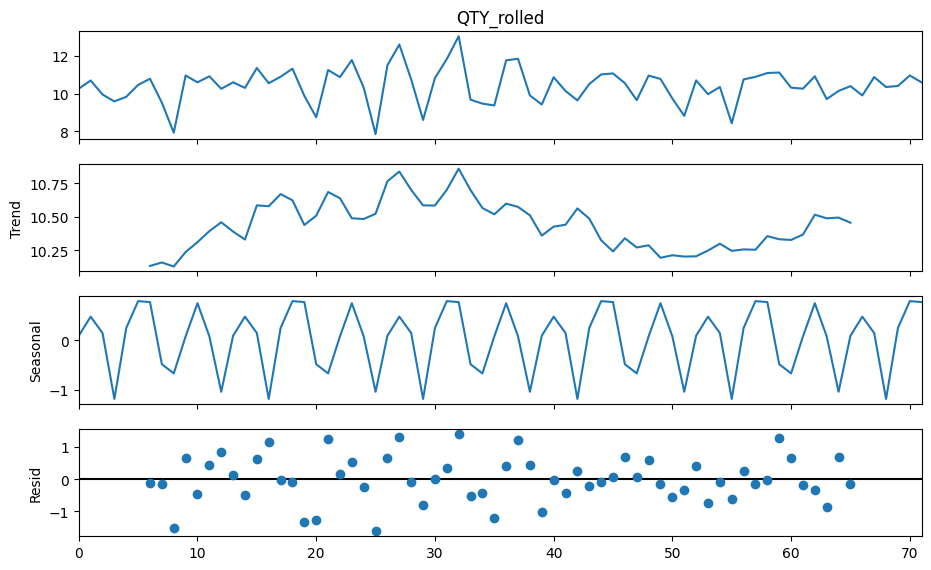

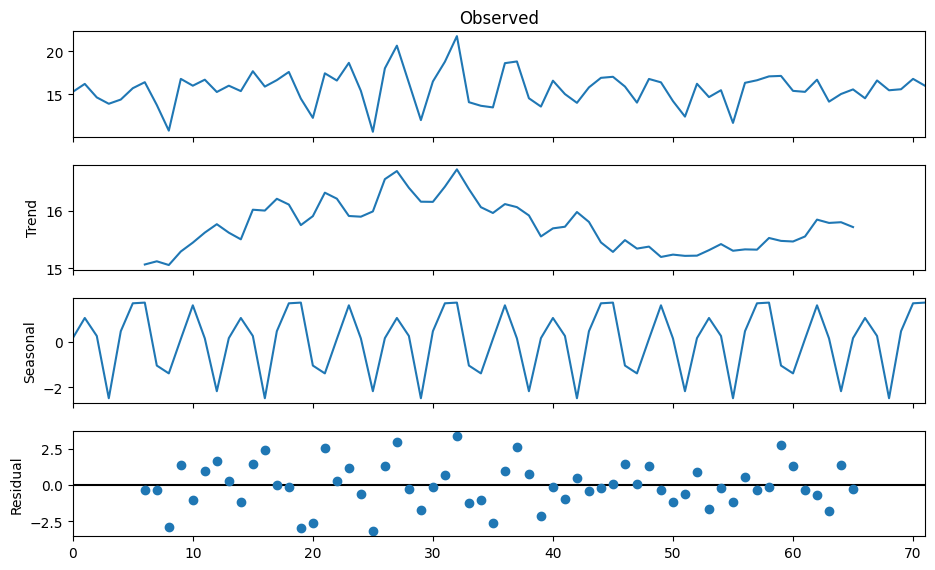

In [81]:
result = seasonal_decompose(qty_log, model='additive', period=13)  
fig = result.plot()
fig.set_size_inches(10, 6)
plt.show()

result = seasonal_decompose(qty_boxcox, model='additive', period=13)  
fig = result.plot()
fig.set_size_inches(10, 6)
plt.show()


STL Decomposition

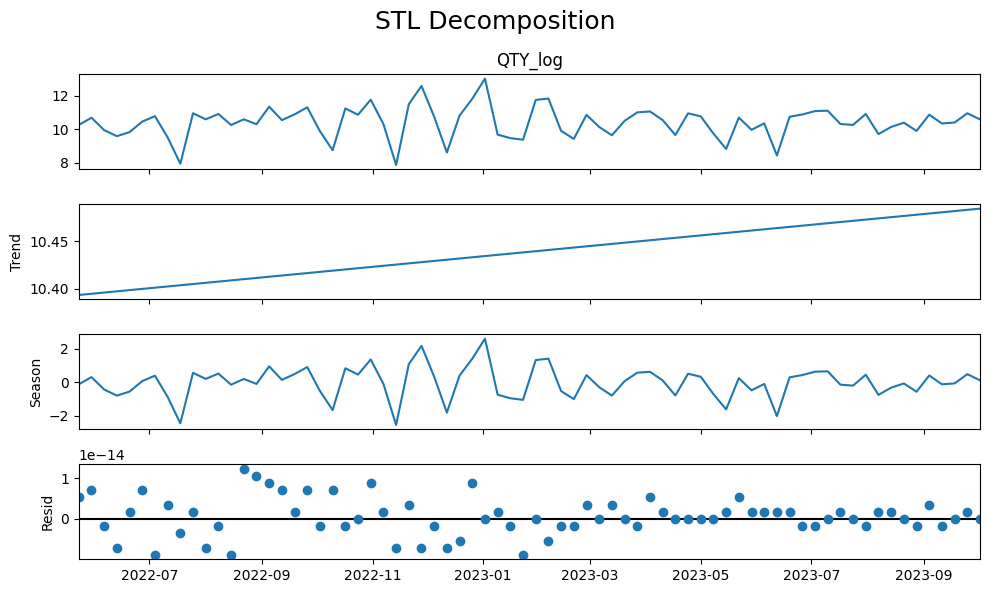

In [82]:
#STL Decomposition
from statsmodels.tsa.seasonal import STL
df_weekly.set_index('Date of Invoice', inplace=True)

# STL expects a datetime index with frequency
df_weekly.index = pd.to_datetime(df_weekly.index)
df_weekly = df_weekly.asfreq('W-MON')

# STL Decomposition (seasonal_period=53 closer to 52 for weekly data)
stl = STL(df_weekly['QTY_log'], seasonal=53)
result = stl.fit()

# Plot the components
fig = result.plot()
fig.set_size_inches(10, 6)
plt.suptitle("STL Decomposition", fontsize=18)
plt.tight_layout()
plt.show()

ADF TEST


ADF Test for Differencing Level: 0
ADF Statistic: -3.3532378159411853
p-value: 0.012660110712546855
Critical Value (1%): -3.5352168748293127
Critical Value (5%): -2.9071540828402367
Critical Value (10%): -2.5911025443786984

The series is stationary (reject null hypothesis)

Total differencing applied: 0


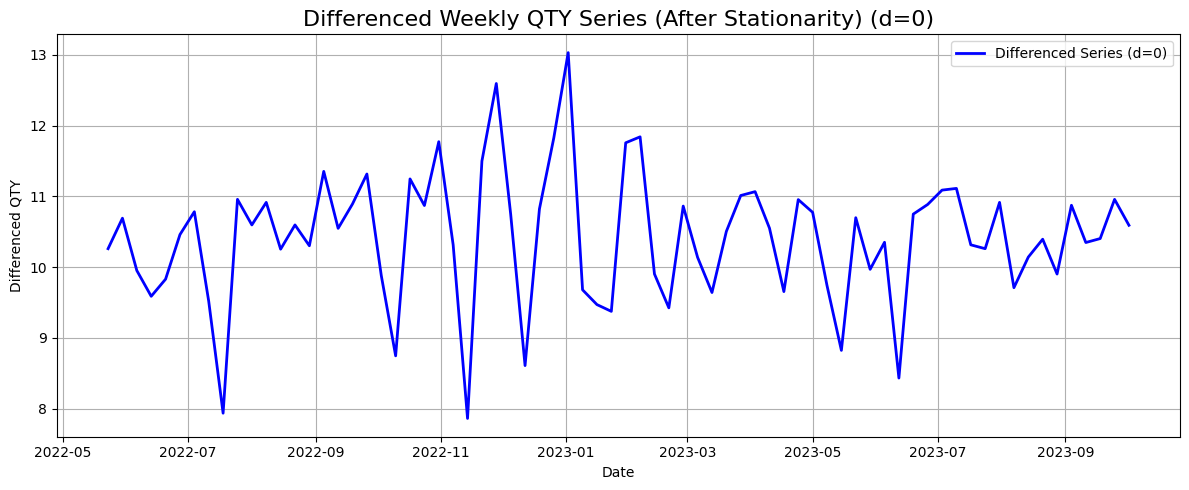

In [83]:
# Run ADF on QTY_rolled column
diff_series = df_weekly['QTY_log'].copy()
d = 0  # Differencing counter

while True:
    print(f"\nADF Test for Differencing Level: {d}")
    result = adfuller(diff_series.dropna())

    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value}")

    if result[1] < 0.05:
        print("\nThe series is stationary (reject null hypothesis)")
        break
    else:
        print("The series is non-stationary, applying differencing...")
        diff_series = diff_series.diff().dropna()
        d += 1

print(f"\nTotal differencing applied: {d}")

# Plotting the differenced series
plt.figure(figsize=(12, 5))
plt.plot(diff_series, color='blue', linewidth=2, label=f'Differenced Series (d={d})')
plt.title(f'Differenced Weekly QTY Series (After Stationarity) (d={d})', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Differenced QTY')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



ACF & PACF Graph

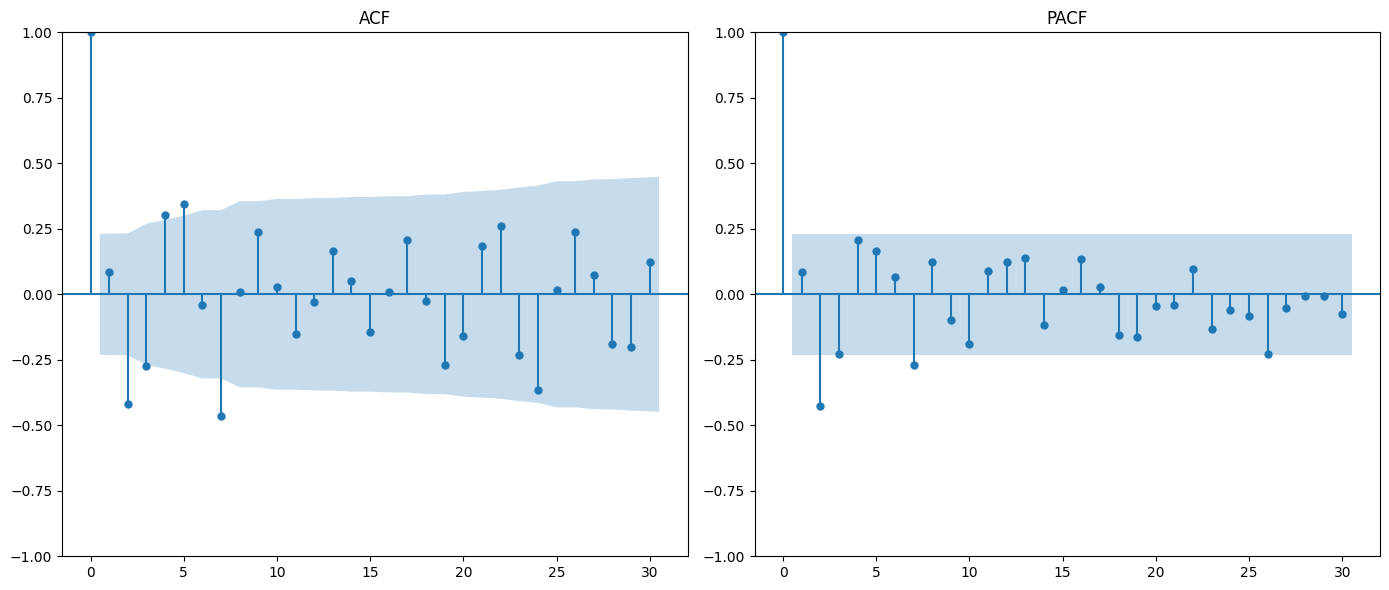

In [84]:
#non - seasonal & seasonal ACF & PACF
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(diff_series, lags=30, ax=plt.gca())
plt.title('ACF')

plt.subplot(1, 2, 2)
plot_pacf(diff_series, lags=30, ax=plt.gca(), method='ywm')
plt.title('PACF')

plt.tight_layout()
plt.show()


Ljung-Box Test (Statistical Test for White Noise)

In [85]:
# Apply Ljung-Box test on the differenced series
ljung_box_result = acorr_ljungbox(diff_series.dropna(), lags=[10], return_df=True)

print("Ljung-Box Test Result:")
print(ljung_box_result)

# Interpretation
p_value = ljung_box_result['lb_pvalue'].values[0]

if p_value > 0.05:
    print("\nThe series appears to be white noise (p-value > 0.05).")
    print("→ It has no predictable structure. Forecasting may not be meaningful.")
else:
    print("\nThe series is NOT white noise (p-value <= 0.05).")
    print("→ It has autocorrelation and structure that can be modeled.")


Ljung-Box Test Result:
      lb_stat     lb_pvalue
10  58.926959  5.781037e-09

The series is NOT white noise (p-value <= 0.05).
→ It has autocorrelation and structure that can be modeled.


Log Transformation


Naive - MAPE: 24.23%
Moving Average - MAPE: 22.16%
SES - MAPE: 26.84%
Holt Linear - MAPE: 19.07%
Holt-Winters - MAPE: 36.85%
ARIMA - MAPE: 20.01%
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=521.612, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=444.801, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=380.423, Time=0.31 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=353.925, Time=0.22 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=200.289, Time=0.26 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=197.743, Time=0.17 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=320.671, Time=0.38 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=197.039, 

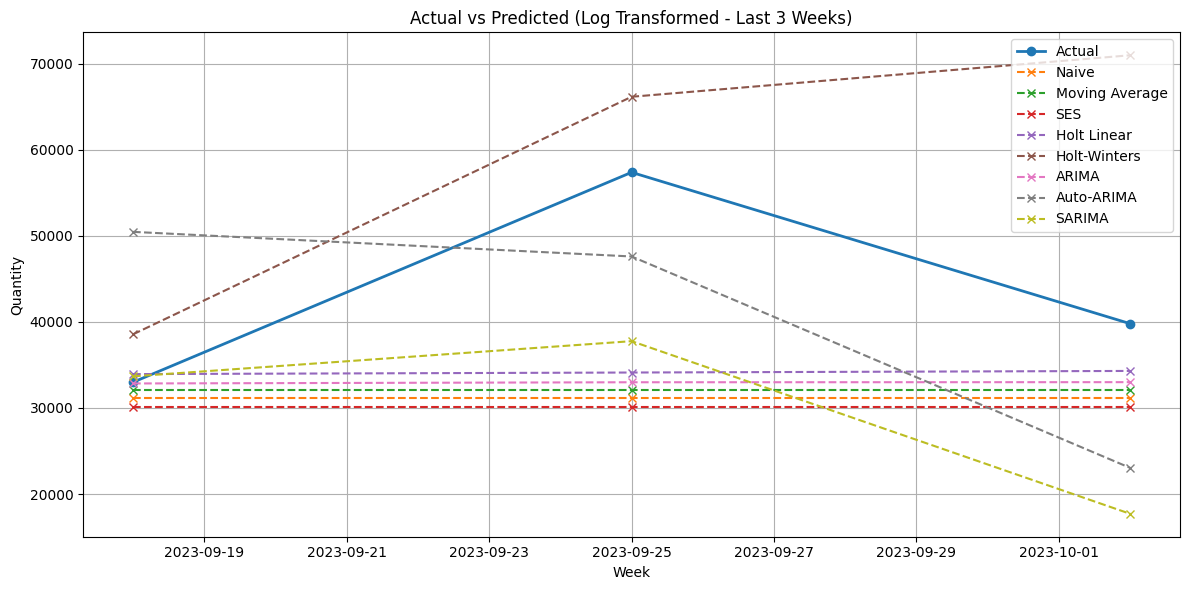

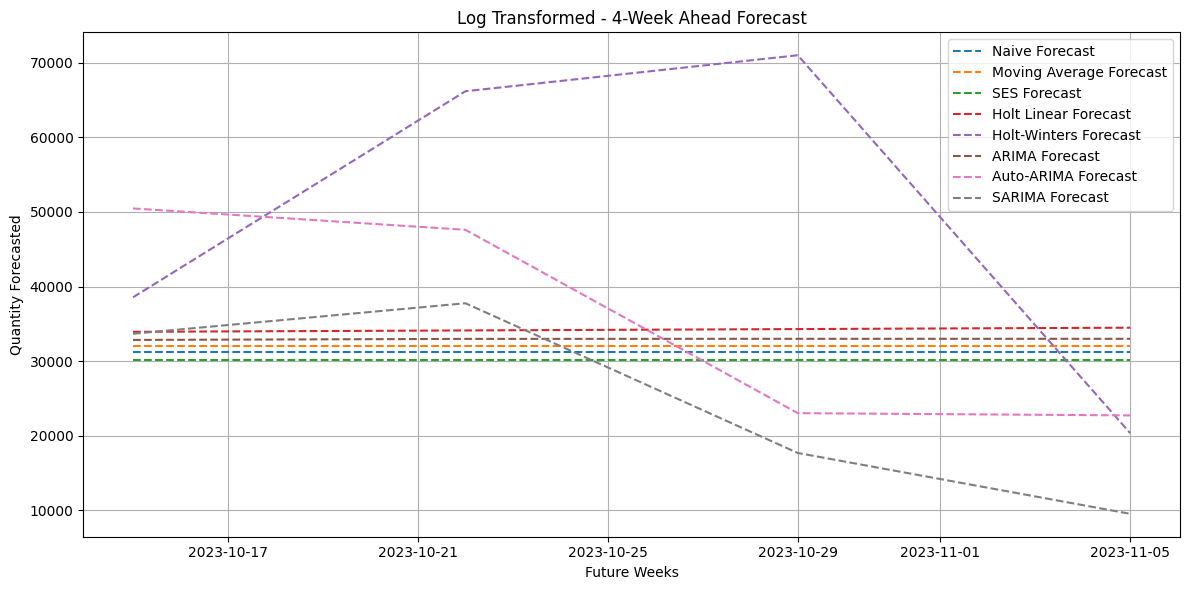


4-Week Forecast by Best Model (Holt Linear):
2023-09-18    33939
2023-09-25    34122
2023-10-02    34306
2023-10-09    34491
Freq: W-MON, dtype: int64


In [102]:
warnings.filterwarnings("ignore")

train = df_weekly[:-3]
test = df_weekly[-3:]
y_train = train['QTY_rolled']
y_test = test['QTY_rolled']

# Handle zero or negative values in the data before log transformation
y_train_clean = y_train.copy()
y_test_clean = y_test.copy()

# Replace zero or negative values with small positive values
y_train_clean[y_train_clean <= 0] = 1e-6
y_test_clean[y_test_clean <= 0] = 1e-6

# Log-transform train and test series
y_train_log = np.log1p(y_train_clean)
y_test_log = np.log1p(y_test_clean)

best_method = None
best_mape = float('inf')
results = {}
forecast_4weeks = {}
test_forecasts = {}

def evaluate_model(name, forecast_test_log, forecast_future_log):
    global best_method, best_mape
    try:
        # Inverse transformation
        forecast_test = np.round(np.expm1(forecast_test_log)).astype(int)
        forecast_future = np.round(np.expm1(forecast_future_log)).astype(int)

        # Calculate MAPE
        mape = mean_absolute_percentage_error(y_test, forecast_test)
        results[name] = mape
        test_forecasts[name] = forecast_test
        forecast_4weeks[name] = forecast_future

        if mape < best_mape:
            best_mape = mape
            best_method = name
        print(f"{name} - MAPE: {mape * 100:.2f}%")
    except Exception as e:
        print(f"{name} - Error: {e}")

# Models

# Naive model
try:
    naive_test = [y_train_log.iloc[-1]] * 3
    naive_future = [y_train_log.iloc[-1]] * 4
    evaluate_model("Naive", naive_test, naive_future)
except Exception as e:
    print("Naive - Error:", e)

# Moving Average model
try:
    ma_test = [y_train_log[-3:].mean()] * 3
    ma_future = [y_train_log[-3:].mean()] * 4
    evaluate_model("Moving Average", ma_test, ma_future)
except Exception as e:
    print("Moving Average - Error:", e)

# Simple Exponential Smoothing (SES)
try:
    ses_model = SimpleExpSmoothing(y_train_log).fit()
    ses_test = ses_model.forecast(3)
    ses_future = ses_model.forecast(4)
    evaluate_model("SES", ses_test, ses_future)
except Exception as e:
    print("SES - Error:", e)

# Holt Linear
try:
    holt_model = Holt(y_train_log).fit()
    holt_test = holt_model.forecast(3)
    holt_future = holt_model.forecast(4)
    evaluate_model("Holt Linear", holt_test, holt_future)
except Exception as e:
    print("Holt Linear - Error:", e)

# Holt-Winters
try:
    hw_model = ExponentialSmoothing(y_train_log, seasonal='mul', seasonal_periods=13).fit()
    hw_test = hw_model.forecast(3)
    hw_future = hw_model.forecast(4)
    evaluate_model("Holt-Winters", hw_test, hw_future)
except Exception as e:
    print("Holt-Winters - Error:", e)

# ARIMA
try:
    arima_model = ARIMA(y_train_log, order=(1,0,0)).fit()
    arima_test = arima_model.forecast(3)
    arima_future = arima_model.forecast(4)
    evaluate_model("ARIMA", arima_test, arima_future)
except Exception as e:
    print("ARIMA - Error:", e)

# Auto-ARIMA
try:
    auto_model = auto_arima(y_train_log, seasonal=False, stepwise=True, trace=True)
    auto_test = auto_model.predict(n_periods=3)
    auto_future = auto_model.predict(n_periods=4)
    evaluate_model("Auto-ARIMA", auto_test, auto_future)
except Exception as e:
    print("Auto-ARIMA - Error:", e)

# SARIMA
try:
    sarima_model = SARIMAX(y_train_log, order=(1,0,0), seasonal_order=(1, 0, 0, 52)).fit()
    sarima_test = sarima_model.forecast(3)
    sarima_future = sarima_model.forecast(4)
    evaluate_model("SARIMA", sarima_test, sarima_future)
except Exception as e:
    print("SARIMA - Error:", e)

# Output best method
if best_mape < 0.10:
    print(f"\n✅ Best method: {best_method} with MAPE: {best_mape * 100:.2f}%")
else:
    print("\n⚠️ No method achieved MAPE < 10%")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label="Actual", marker='o', linewidth=2)
for name, forecast in test_forecasts.items():
    plt.plot(y_test.index, forecast, label=f"{name}", linestyle='--', marker='x')
plt.title("Actual vs Predicted (Log Transformed - Last 3 Weeks)")
plt.xlabel("Week")
plt.ylabel("Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot next 4-week forecasts
plt.figure(figsize=(12, 6))
future_index = pd.date_range(start=y_test.index[-1] + pd.Timedelta(weeks=1), periods=4, freq='W')
for name, forecast in forecast_4weeks.items():
    plt.plot(future_index, forecast, label=f"{name} Forecast", linestyle='--')
plt.title("Log Transformed - 4-Week Ahead Forecast")
plt.xlabel("Future Weeks")
plt.ylabel("Quantity Forecasted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the best 4-week forecast
if best_method and best_method in forecast_4weeks:
    print(f"\n4-Week Forecast by Best Model ({best_method}):")
    print(np.round(forecast_4weeks[best_method], 2))
else:
    print("\nNo valid forecast available from models with MAPE < 10%")


MAPE for the last 3 weeks: 36.85%

Forecasted values for the next 4 weeks:
Week 1: 38561.80
Week 2: 66167.58
Week 3: 70990.68
Week 4: 20367.88


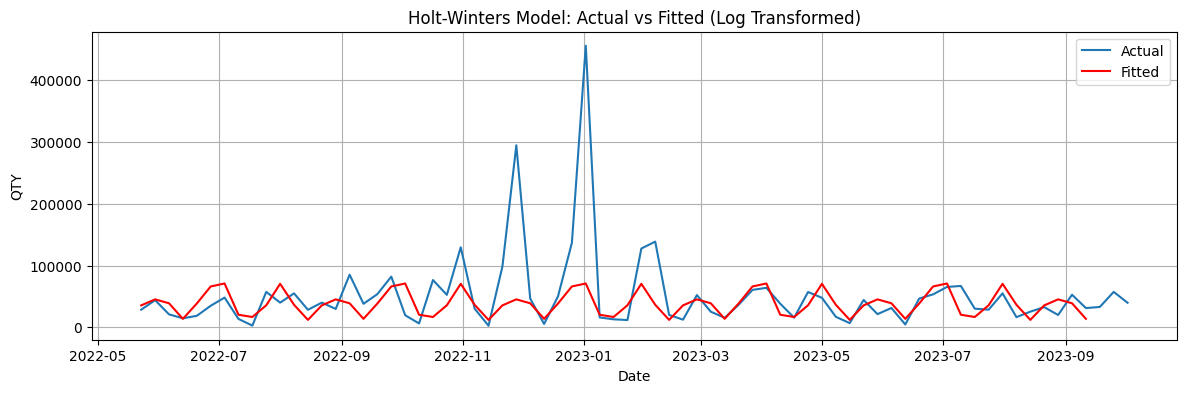

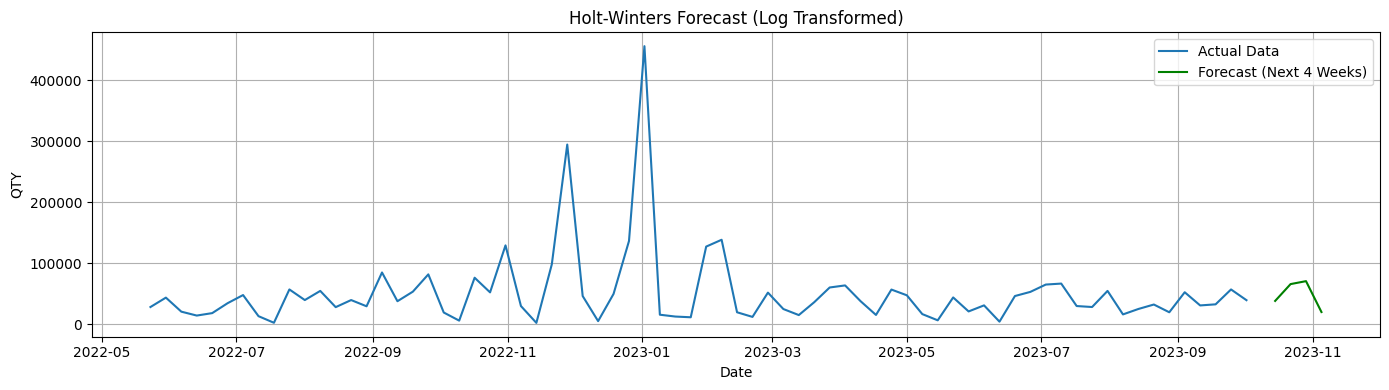

In [87]:
# --- LOG TRANSFORMATION ---
df_weekly['QTY_log'] = np.log1p(df_weekly['QTY_rolled'])

# --- SPLIT DATA ---
train_data = df_weekly[:-3]  # All data except last 3 weeks
test_data = df_weekly[-3:]   # Last 3 weeks

# --- BUILD MODEL ---
model = ExponentialSmoothing(
    train_data['QTY_log'],
    seasonal='mul',
    seasonal_periods=13
)

# --- FIT MODEL ---
model_fit = model.fit()

# --- PREDICT LAST 3 WEEKS (TEST DATA) ---
predicted_values_log = model_fit.forecast(steps=3)
actual_values_log = test_data['QTY_log'].values

# --- INVERSE TRANSFORMATION ---
predicted_values = np.exp(predicted_values_log)
actual_values = np.exp(actual_values_log)

# --- CALCULATE MAPE ---
mape = mean_absolute_percentage_error(actual_values, predicted_values)
print(f"MAPE for the last 3 weeks: {mape * 100:.2f}%")

# --- FORECAST NEXT 4 WEEKS ---
forecast_values_log = model_fit.forecast(steps=4)
forecast_values = np.exp(forecast_values_log)

# --- PRINT FORECASTED VALUES ---
print("\nForecasted values for the next 4 weeks:")
for i, value in enumerate(forecast_values, start=1):
    print(f"Week {i}: {value:.2f}")

# --- PLOT ACTUAL vs FITTED ---
plt.figure(figsize=(14, 4))
plt.plot(df_weekly.index, np.exp(df_weekly['QTY_log']), label='Actual')  # Inverse actual values
plt.plot(train_data.index, np.exp(model_fit.fittedvalues), color='red', label='Fitted')  # Inverse fitted values
plt.title('Holt-Winters Model: Actual vs Fitted (Log Transformed)')
plt.xlabel('Date')
plt.ylabel('QTY')
plt.legend()
plt.grid(True)
plt.show()

# --- PLOT FORECAST ---
future_weeks = pd.date_range(df_weekly.index[-1] + pd.Timedelta(weeks=1), periods=4, freq='W')

plt.figure(figsize=(14, 4))
plt.plot(df_weekly.index, np.exp(df_weekly['QTY_log']), label='Actual Data')
plt.plot(future_weeks, forecast_values, label='Forecast (Next 4 Weeks)', color='green')
plt.title('Holt-Winters Forecast (Log Transformed)')
plt.xlabel('Date')
plt.ylabel('QTY')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


                               SARIMAX Results                                
Dep. Variable:                QTY_log   No. Observations:                   69
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -93.789
Date:                Tue, 29 Apr 2025   AIC                            193.579
Time:                        16:51:58   BIC                            200.281
Sample:                    05-23-2022   HQIC                           196.238
                         - 09-11-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.4044      0.126     82.472      0.000      10.157      10.652
ar.L1          0.0827      0.127      0.651      0.515      -0.166       0.332
sigma2         0.8874      0.149      5.942      0.0

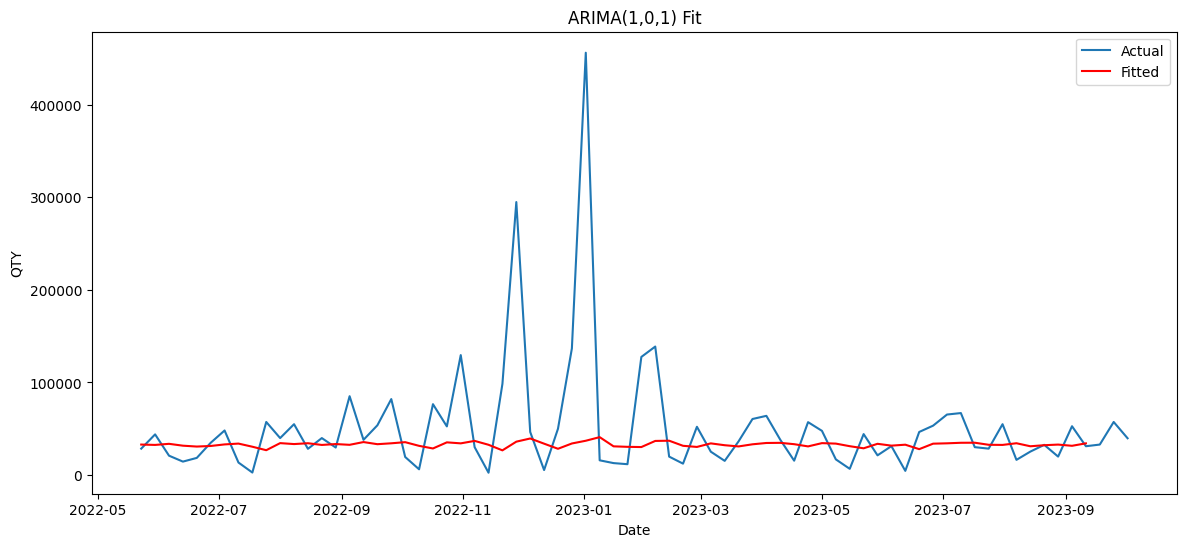

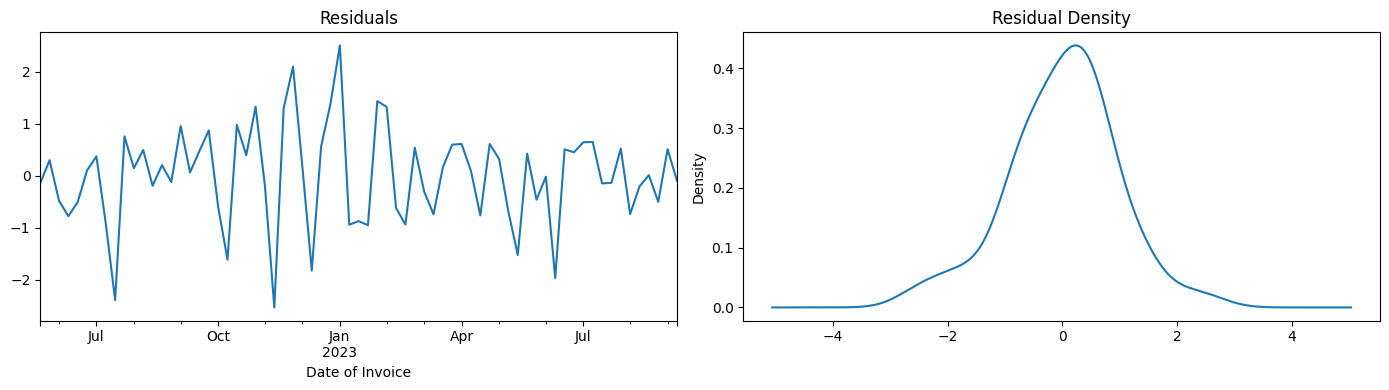

MAPE for the last 3 weeks: 20.01%
2023-09-18    22026.0
2023-09-25    22026.0
2023-10-02    22026.0
2023-10-09    22026.0
Freq: W-MON, Name: predicted_mean, dtype: float64


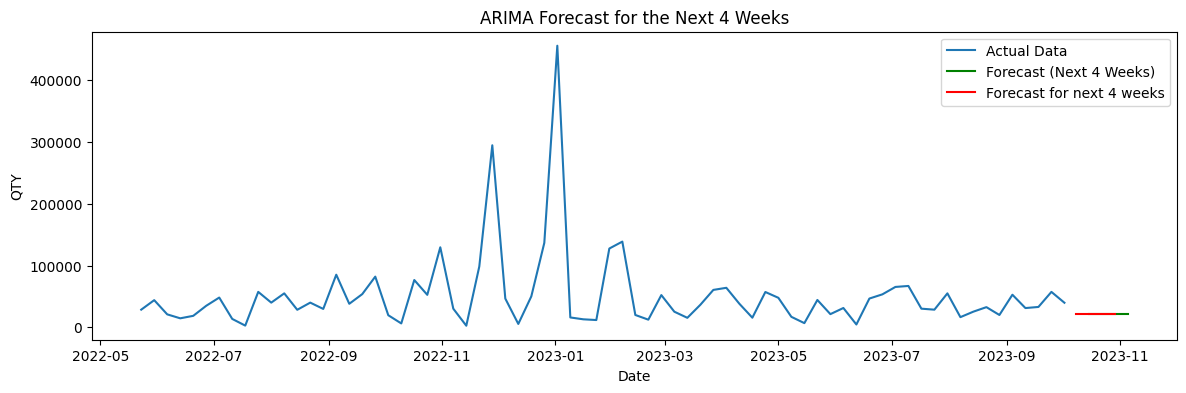

In [101]:
#After applying BOX COX apply ARIMA(1, 0, 1)
# ARIMA(p=1, d=0, q=1)

# Split data (train and test)
train_data = df_weekly[:-3]  # All data except the last 3 weeks
test_data = df_weekly[-3:]   # Last 3 weeks

# Fit ARIMA model
model = ARIMA(train_data['QTY_log'], order=(1,0,0))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Plot the fitted values vs original
plt.figure(figsize=(14, 6))
plt.plot(df_weekly.index, np.exp(df_weekly['QTY_log']), label='Actual')  # Inverse actual values
plt.plot(train_data.index, np.exp(model_fit.fittedvalues), color='red', label='Fitted')  # Inverse fitted values
plt.title('ARIMA(1,0,1) Fit')
plt.xlabel('Date')
plt.ylabel('QTY')
plt.legend()
plt.show()

# Plot residuals
residuals = model_fit.resid

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
residuals.plot(title="Residuals")

plt.subplot(1, 2, 2)
residuals.plot(kind='kde', title='Residual Density')

plt.tight_layout()
plt.show()

# Predict the last 3 weeks
predicted_values_log = model_fit.forecast(steps=3)

# Calculate MAPE (only for the last 3 weeks)
# Actual values for the last 3 weeks (replace with actual test data values when available)
actual_values_log = test_data['QTY_log'].values

# --- INVERSE TRANSFORMATION ---
predicted_values = np.exp(predicted_values_log)
actual_values = np.exp(actual_values_log)

# Calculate MAPE for the last 3 weeks (Test Period)
mape = mean_absolute_percentage_error(actual_values, predicted_values)
print(f"MAPE for the last 3 weeks: {mape * 100:.2f}%")

# Forecast the next 4 weeks (future forecast)
forecast_values_log = model_fit.forecast(steps=4).astype(int)
forecast_values = np.exp(forecast_values_log)
print(np.round(forecast_values))

# Plotting the forecasted values
plt.figure(figsize=(14, 4))
plt.plot(df_weekly.index, np.exp(df_weekly['QTY_log']), label='Actual Data')
plt.plot(future_weeks, forecast_values, label='Forecast (Next 4 Weeks)', color='green')
plt.plot(pd.date_range(df_weekly.index[-1], periods=4, freq='W'), forecast_values, label='Forecast for next 4 weeks', color='red')
plt.title('ARIMA Forecast for the Next 4 Weeks')
plt.xlabel('Date')
plt.ylabel('QTY')
plt.legend()
plt.show()


                                     SARIMAX Results                                      
Dep. Variable:                            QTY_log   No. Observations:                   69
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 52)   Log Likelihood                 -21.352
Date:                            Tue, 29 Apr 2025   AIC                             48.703
Time:                                    17:05:43   BIC                             51.021
Sample:                                05-23-2022   HQIC                            48.822
                                     - 09-11-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9916      0.029     33.807      0.000       0.934       1.049
ar.S.L52       0.1583      0.411   

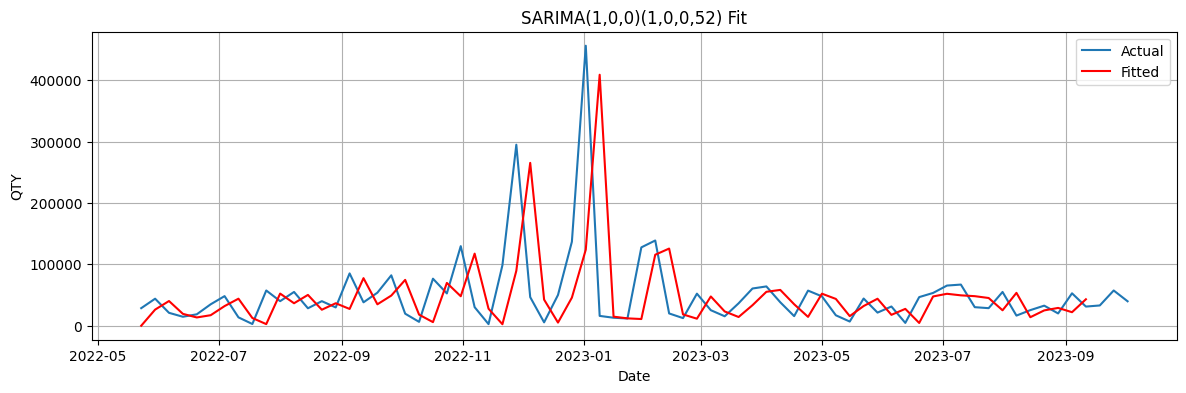

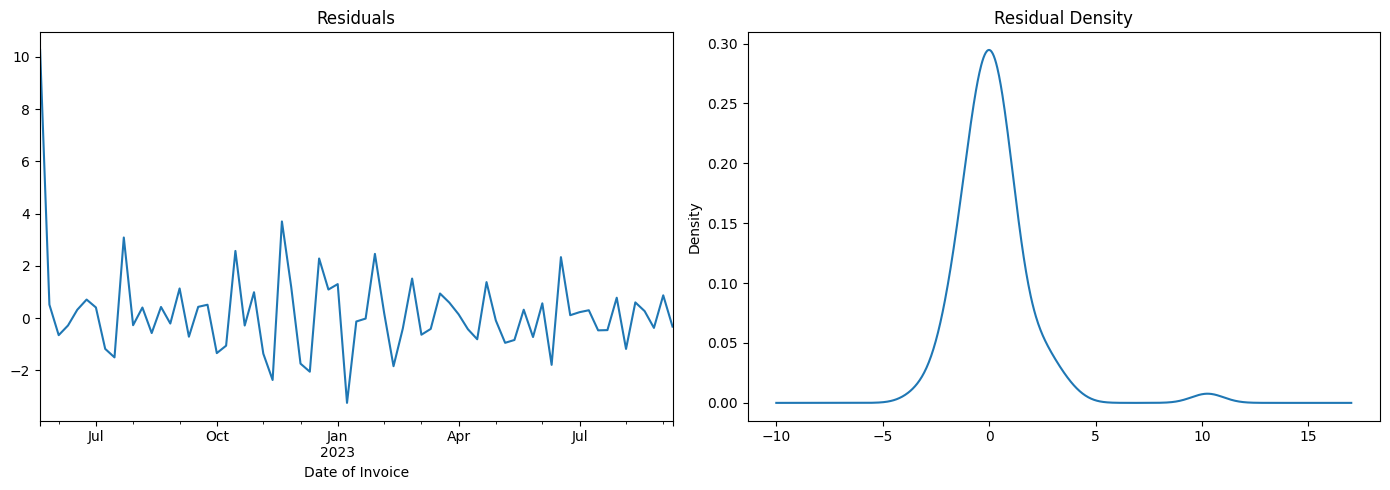

MAPE for the last 3 weeks: 32.42%
2023-10-09    17592.0
2023-10-16    24351.0
2023-10-23    21396.0
2023-10-30    23028.0
Freq: W-MON, Name: predicted_mean, dtype: float64


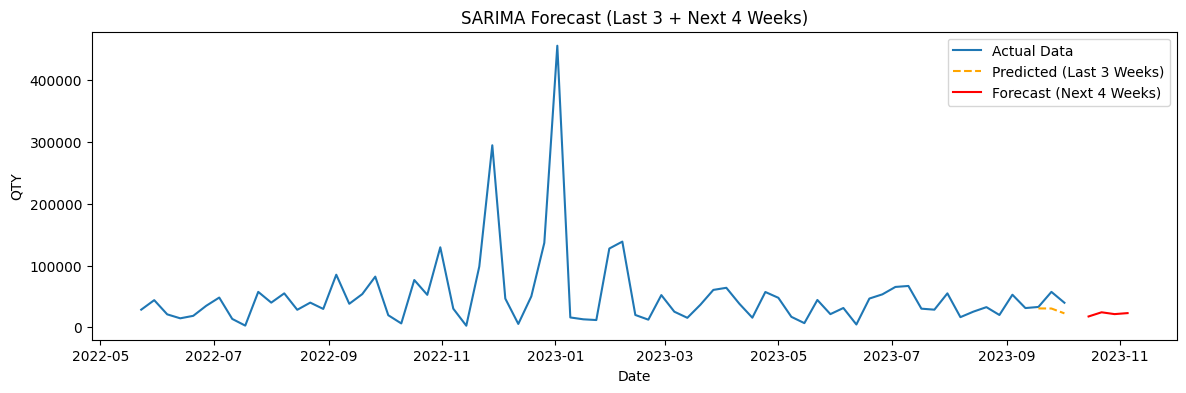

In [104]:
#SARIMA
# Step 1: Split data (train and test)
train_data = df_weekly[:-3]  # All data except the last 3 weeks
test_data = df_weekly[-3:]   # Last 3 weeks

# Define SARIMA model (example: seasonal_order=(1, 0, 10, 52) for weekly seasonality)
model = SARIMAX(train_data['QTY_log'],
                order=(1, 0, 0),
                seasonal_order=(1, 0, 0, 52),  # You can tweak this based on ACF/PACF or grid search
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# --- PLOT ACTUAL vs FITTED ---
plt.figure(figsize=(14, 4))
plt.plot(df_weekly.index, np.exp(df_weekly['QTY_log']), label='Actual')  # Inverse actual values
plt.plot(train_data.index, np.exp(model_fit.fittedvalues), color='red', label='Fitted')  # Inverse fitted values
plt.title('SARIMA(1,0,0)(1,0,0,52) Fit')
plt.xlabel('Date')
plt.ylabel('QTY')
plt.legend()
plt.grid(True)
plt.show()

# Plot residuals
residuals = model_fit.resid

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
residuals.plot(title="Residuals")

plt.subplot(1, 2, 2)
residuals.plot(kind='kde', title='Residual Density')

plt.tight_layout()
plt.show()

# Step 3: Predict the last 3 weeks
predicted_values_log = model_fit.forecast(steps=3)
actual_values_log = test_data['QTY_log'].values

#inverse
predicted_values = np.exp(predicted_values_log)
actual_values = np.exp(actual_values_log)

# Step 4: Calculate MAPE for the last 3 weeks
mape = mean_absolute_percentage_error(actual_values, predicted_values)
print(f"MAPE for the last 3 weeks: {mape * 100:.2f}%")

# Step 5: Forecast the next 4 weeks (future forecast)
forecast_values_log = model_fit.forecast(steps=7)[-4:]  # last 4 from 7 to keep continuity
forecasted_values = np.exp(forecast_values_log)
print(np.round(forecasted_values))

# Forecast dates for plotting
forecast_dates = pd.date_range(df_weekly.index[-1] + pd.Timedelta(weeks=1), periods=4, freq='W')

# Plotting the forecasted values
plt.figure(figsize=(14, 4))
plt.plot(df_weekly.index, np.exp(df_weekly['QTY_log']), label='Actual Data')
plt.plot(test_data.index, predicted_values, label='Predicted (Last 3 Weeks)', color='orange', linestyle='--')
plt.plot(forecast_dates, forecasted_values, label='Forecast (Next 4 Weeks)', color='red')
plt.title('SARIMA Forecast (Last 3 + Next 4 Weeks)')
plt.xlabel('Date')
plt.ylabel('QTY')
plt.legend()
plt.show()



BoxCox Transformation

Naive - MAPE: 24.23%
Moving Average - MAPE: 21.71%
SES - MAPE: 23.03%
Holt Linear - MAPE: 19.32%
Holt-Winters - MAPE: 39.75%
ARIMA - MAPE: 19.14%
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=578.639, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=341.098, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=506.119, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=344.100, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=297.915, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=296.598, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=296.453, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=297.354, Time=0.24 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=292.072, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2

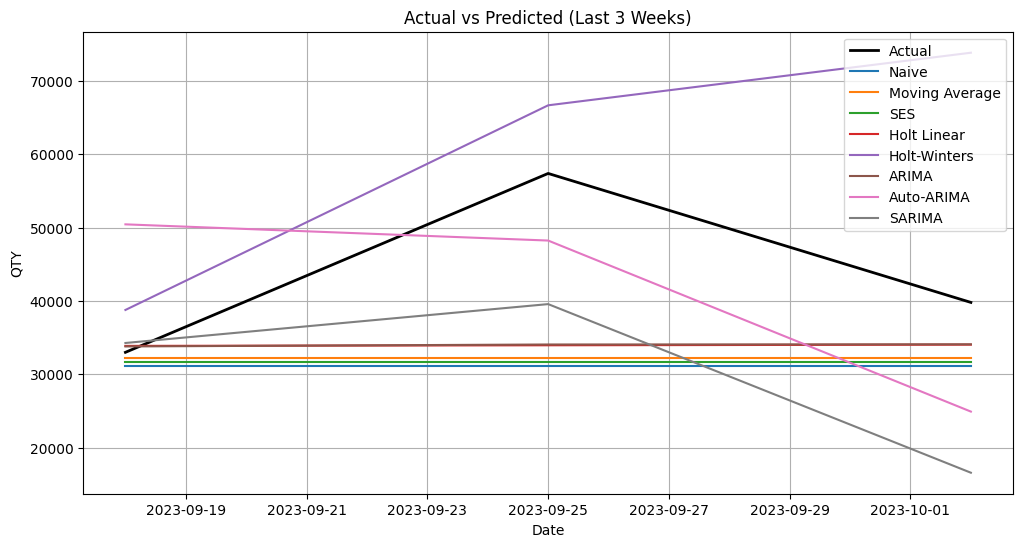

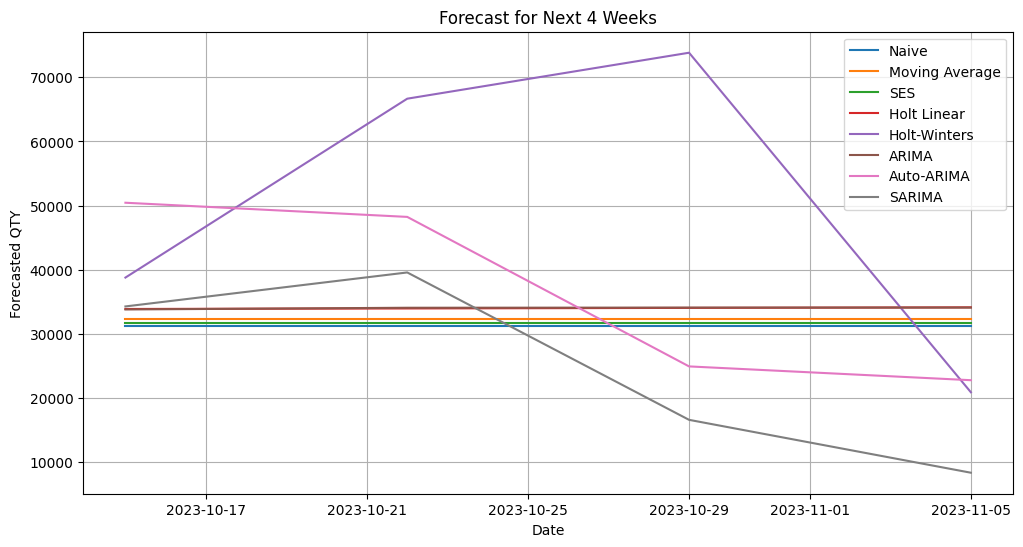

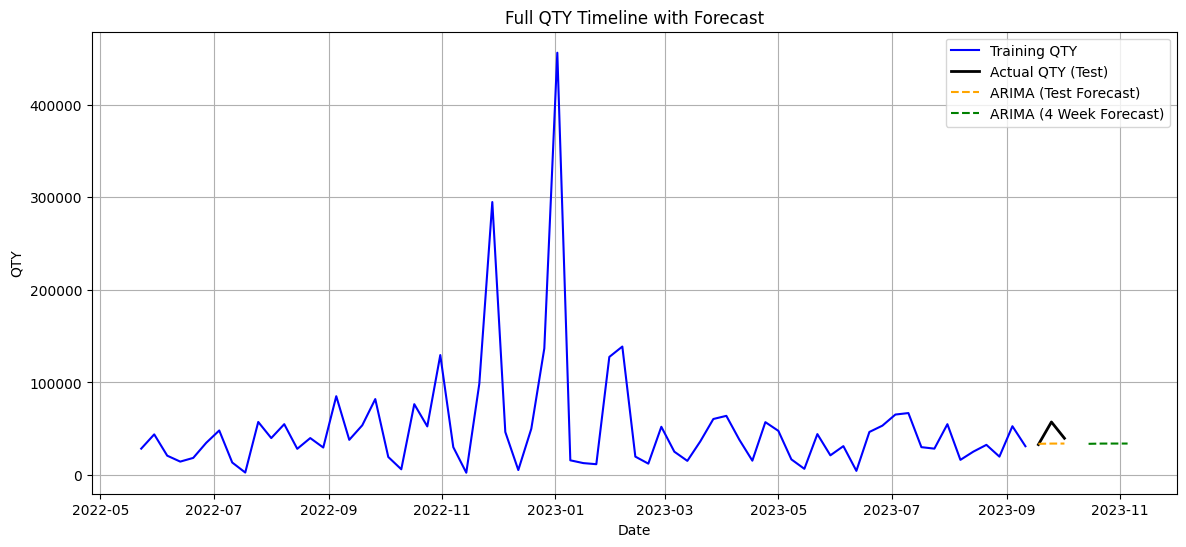


🔮 4-Week Forecast by Best Model (ARIMA):
2023-09-18    33797
2023-09-25    34063
2023-10-02    34090
2023-10-09    34092
Freq: W-MON, Name: predicted_mean, dtype: int64


In [ ]:
# Assume df_weekly and lmbda are already defined

train = df_weekly[:-3]
test = df_weekly[-3:]
y_train = train['QTY_boxcox']
y_test = test['QTY_boxcox']

best_method = None
best_mape = float('inf')
results = {}
test_forecasts = {}
forecast_4weeks = {}

# Store fitted lambda used for boxcox
fitted_lambda = lmbda

# Updated evaluation function with inverse transformation
def evaluate_model(name, forecast_test, forecast_future):
    global best_method, best_mape
    try:
        # Inverse Box-Cox for accurate MAPE
        actuals = inv_boxcox(y_test, fitted_lambda)
        preds = inv_boxcox(forecast_test, fitted_lambda)
        mape = mean_absolute_percentage_error(actuals, preds)

        results[name] = mape
        test_forecasts[name] = np.round(preds).astype(int)
        forecast_4weeks[name] = np.round(inv_boxcox(forecast_future, fitted_lambda)).astype(int)

        if mape < best_mape:
            best_mape = mape
            best_method = name
        print(f"{name} - MAPE: {mape * 100:.2f}%")
    except Exception as e:
        print(f"{name} - Error: {e}")

# Naive Forecast
try:
    naive_test = [y_train.iloc[-1]] * 3
    naive_future = [y_train.iloc[-1]] * 4
    evaluate_model("Naive", naive_test, naive_future)
except Exception as e:
    print("Naive - Error:", e)

# Moving Average
try:
    ma_test = [y_train[-3:].mean()] * 3
    ma_future = [y_train[-3:].mean()] * 4
    evaluate_model("Moving Average", ma_test, ma_future)
except Exception as e:
    print("Moving Average - Error:", e)

# Simple Exponential Smoothing
try:
    ses_model = SimpleExpSmoothing(y_train).fit()
    ses_forecast = ses_model.forecast(3)
    ses_future = ses_model.forecast(4)
    evaluate_model("SES", ses_forecast, ses_future)
except Exception as e:
    print("SES - Error:", e)

# Holt’s Linear Trend
try:
    holt_model = Holt(y_train).fit()
    holt_forecast = holt_model.forecast(3)
    holt_future = holt_model.forecast(4)
    evaluate_model("Holt Linear", holt_forecast, holt_future)
except Exception as e:
    print("Holt Linear - Error:", e)

# Holt-Winters Seasonal
try:
    hw_model = ExponentialSmoothing(y_train, seasonal='mul', seasonal_periods=13).fit()
    hw_forecast = hw_model.forecast(3)
    hw_future = hw_model.forecast(4)
    evaluate_model("Holt-Winters", hw_forecast, hw_future)
except Exception as e:
    print("Holt-Winters - Error:", e)

# ARIMA
try:
    arima_model = ARIMA(y_train, order=(1, 0, 0)).fit()
    arima_forecast = arima_model.forecast(3)
    arima_future = arima_model.forecast(4)
    evaluate_model("ARIMA", arima_forecast, arima_future)
except Exception as e:
    print("ARIMA - Error:", e)

# Auto ARIMA
try:
    auto_model = auto_arima(y_train, seasonal=False, stepwise=True, trace=True)
    auto_test = auto_model.predict(n_periods=3)
    auto_future = auto_model.predict(n_periods=4)
    evaluate_model("Auto-ARIMA", auto_test, auto_future)
except Exception as e:
    print("Auto-ARIMA - Error:", e)

# SARIMA
try:
    sarima_model = SARIMAX(y_train, order=(1, 0, 0), seasonal_order=(1, 0, 0, 52)).fit()
    sarima_forecast = sarima_model.forecast(3)
    sarima_future = sarima_model.forecast(4)
    evaluate_model("SARIMA", sarima_forecast, sarima_future)
except Exception as e:
    print("SARIMA - Error:", e)

# Output best model
if best_mape < 0.10:
    print(f"\nBest method: {best_method} with MAPE: {best_mape * 100:.2f}%")
else:
    print("\n No method achieved MAPE < 10%")

# Inverse transform for actuals
actual_test = np.round(inv_boxcox(y_test, fitted_lambda)).astype(int)
actual_train = np.round(inv_boxcox(y_train, fitted_lambda)).astype(int)

#  PLOT: Actual vs Predicted for Last 3 Weeks
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, actual_test, label='Actual', color='black', linewidth=2)
for model, forecast in test_forecasts.items():
    plt.plot(y_test.index, forecast, label=model)
plt.title("Actual vs Predicted (Last 3 Weeks)")
plt.xlabel("Date")
plt.ylabel("QTY")
plt.legend()
plt.grid(True)
plt.show()

# PLOT: Forecast for Next 4 Weeks (Original Scale)
future_dates = pd.date_range(start=y_test.index[-1] + pd.Timedelta(weeks=1), periods=4, freq='W')
plt.figure(figsize=(12, 6))
for model, forecast in forecast_4weeks.items():
    plt.plot(future_dates, forecast, label=model)
plt.title("Forecast for Next 4 Weeks")
plt.xlabel("Date")
plt.ylabel("Forecasted QTY")
plt.legend()
plt.grid(True)
plt.show()

# PLOT: Full Timeline (Train + Test + Forecast)
plt.figure(figsize=(14, 6))
plt.plot(y_train.index, actual_train, label='Training QTY', color='blue')
plt.plot(y_test.index, actual_test, label='Actual QTY (Test)', color='black', linewidth=2)
if best_method in test_forecasts:
    plt.plot(y_test.index, test_forecasts[best_method], '--', label=f'{best_method} (Test Forecast)', color='orange')
if best_method in forecast_4weeks:
    plt.plot(future_dates, forecast_4weeks[best_method], '--', label=f'{best_method} (4 Week Forecast)', color='green')
plt.title("Full QTY Timeline with Forecast")
plt.xlabel("Date")
plt.ylabel("QTY")
plt.legend()
plt.grid(True)
plt.show()

#  Final 4-Week Forecast from Best Model
if best_method and best_method in forecast_4weeks:
    print(f"\n 4-Week Forecast by Best Model ({best_method}):")
    print(np.round(forecast_4weeks[best_method], 2))
else:
    print("\n No valid forecast available from models with MAPE < 10%")


MAPE for the last 3 weeks: 39.75%

Forecasted values for the next 4 weeks (after inverse Box-Cox):
Week 1: 38771.73984268615
Week 2: 66674.22122178465
Week 3: 73844.45158746373
Week 4: 20882.29137441126


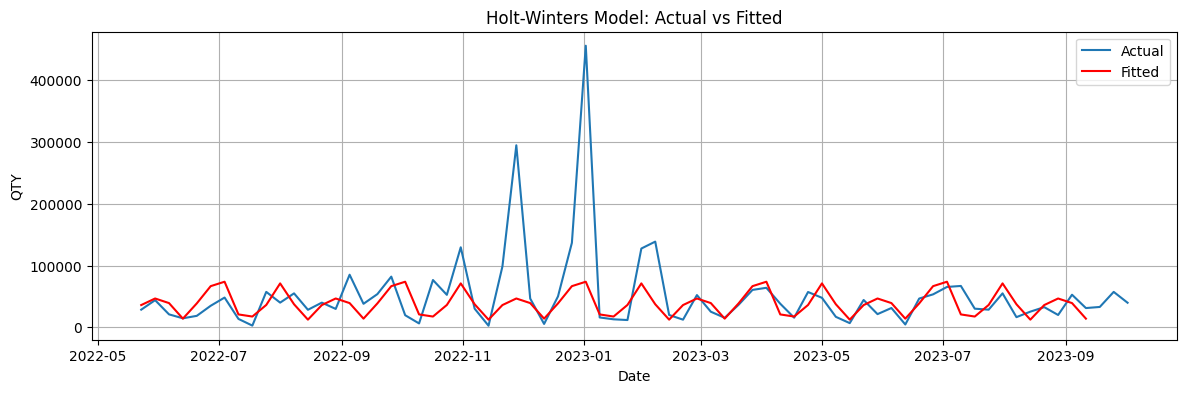

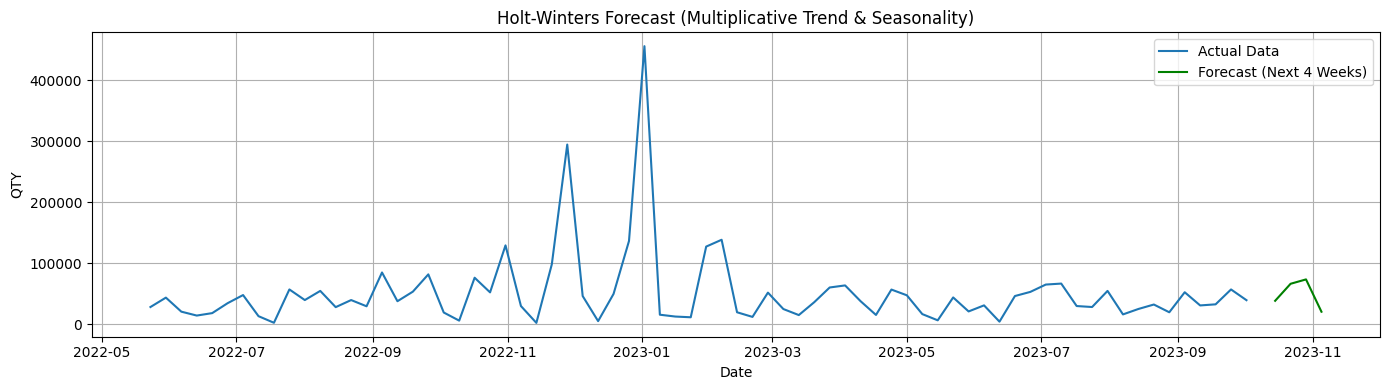

In [111]:
# --- SPLIT DATA ---
train_data = df_weekly[:-3]  # All data except last 3 weeks
test_data = df_weekly[-3:]   # Last 3 weeks

fitted_lambda = lmbda 

# --- BUILD MODEL ---
model = ExponentialSmoothing(
    train_data['QTY_boxcox'],
    seasonal='mul',        # multiplicative seasonality
    seasonal_periods=13    # Assuming weekly data with 13 weeks seasonality
)

# --- FIT MODEL ---
model_fit = model.fit()

# --- PREDICT LAST 3 WEEKS (TEST DATA) ---
predicted_values = model_fit.forecast(steps=3)
actual_values = test_data['QTY_boxcox'].values

# --- INVERSE TRANSFORMATION for predictions and actual values ---
predicted_values_inv = inv_boxcox(predicted_values, fitted_lambda)
actual_values_inv = inv_boxcox(actual_values, fitted_lambda)

# --- CALCULATE MAPE ---
mape = mean_absolute_percentage_error(actual_values_inv, predicted_values_inv)
print(f"MAPE for the last 3 weeks: {mape * 100:.2f}%")

# --- FORECAST NEXT 4 WEEKS ---
forecast_values_boxcox = model_fit.forecast(steps=4)
forecast_values_inv = inv_boxcox(forecast_values_boxcox, fitted_lambda)

# --- PRINT FORECASTED VALUES ---
print("\nForecasted values for the next 4 weeks (after inverse Box-Cox):")
for i, value in enumerate(forecast_values_inv, start=1):
    print(f"Week {i}: {value:}")

# --- PLOT ACTUAL vs FITTED ---
plt.figure(figsize=(14, 4))
plt.plot(df_weekly.index, inv_boxcox(df_weekly['QTY_boxcox'], fitted_lambda), label='Actual')  # Inverse actual values
plt.plot(train_data.index, inv_boxcox(model_fit.fittedvalues, fitted_lambda), color='red', label='Fitted')  # Inverse fitted values
plt.title('Holt-Winters Model: Actual vs Fitted')
plt.xlabel('Date')
plt.ylabel('QTY')
plt.legend()
plt.grid(True)
plt.show()

# --- PLOT FORECAST ---
future_weeks = pd.date_range(df_weekly.index[-1] + pd.Timedelta(weeks=1), periods=4, freq='W')

plt.figure(figsize=(14, 4))
plt.plot(df_weekly.index, inv_boxcox(df_weekly['QTY_boxcox'], fitted_lambda), label='Actual Data')
plt.plot(future_weeks, forecast_values_inv, label='Forecast (Next 4 Weeks)', color='green')
plt.title('Holt-Winters Forecast (Multiplicative Trend & Seasonality)')
plt.xlabel('Date')
plt.ylabel('QTY')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


                               SARIMAX Results                                
Dep. Variable:             QTY_boxcox   No. Observations:                   69
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -145.958
Date:                Tue, 29 Apr 2025   AIC                            297.915
Time:                        17:31:36   BIC                            304.617
Sample:                    05-23-2022   HQIC                           300.574
                         - 09-11-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.6637      0.269     58.149      0.000      15.136      16.192
ar.L1          0.0986      0.125      0.787      0.431      -0.147       0.344
sigma2         4.0254      0.686      5.865      0.0

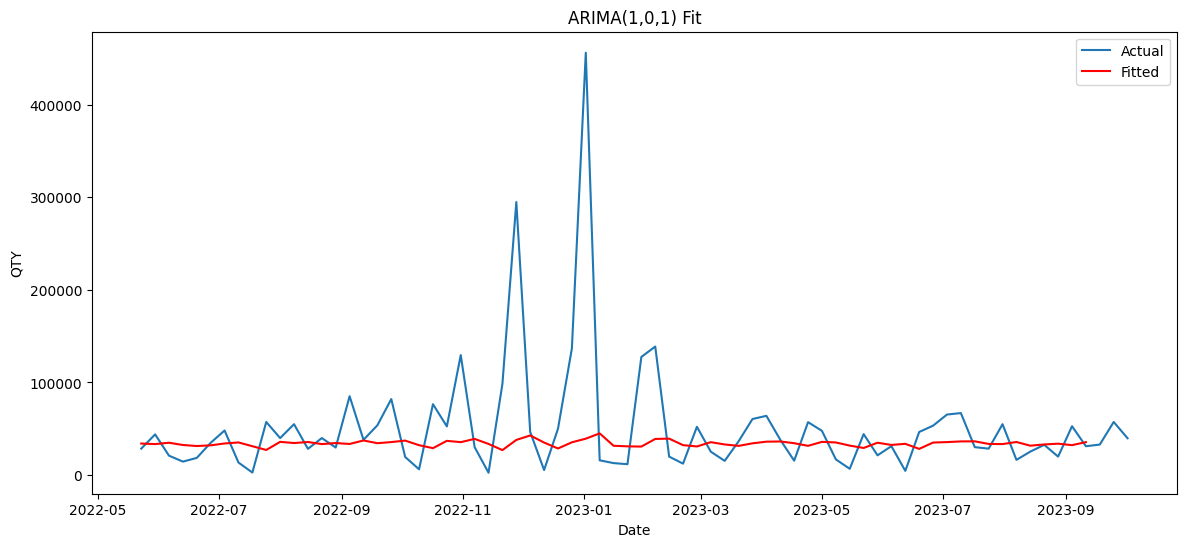

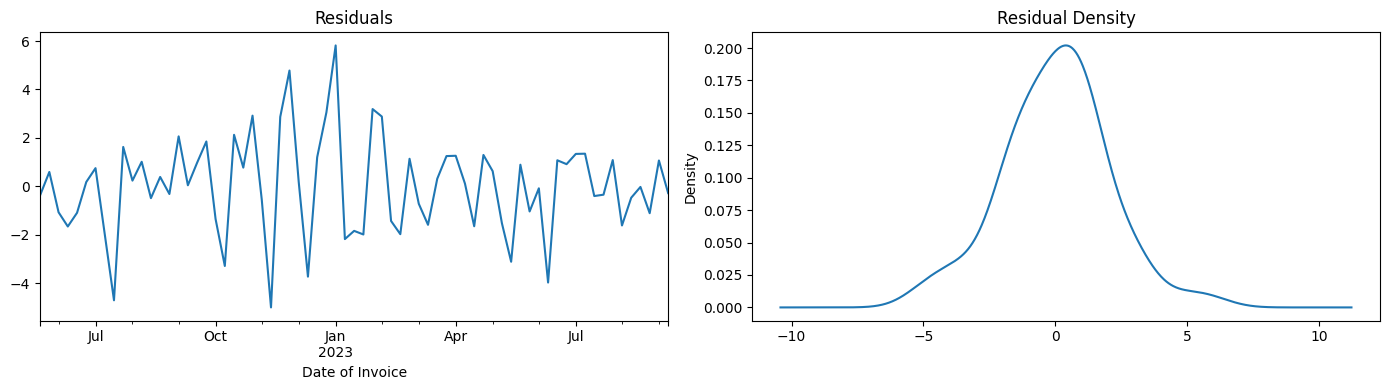

MAPE for the last 3 weeks: 19.14%
2023-10-09    16375.0
2023-10-16    22824.0
2023-10-23    19606.0
2023-10-30    21282.0
Freq: W-MON, Name: predicted_mean, dtype: float64


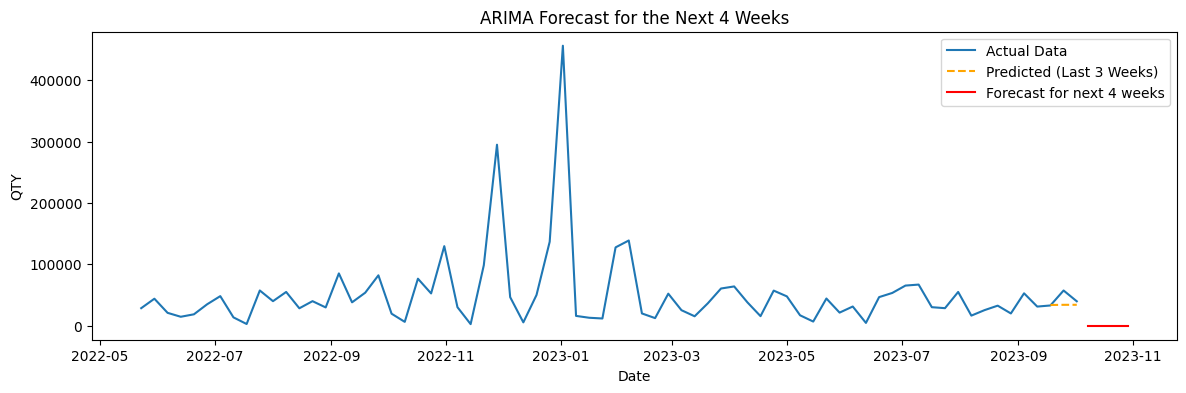

In [117]:
#After applying BOX COX apply ARIMA(1, 0, 0)
# ARIMA(p=1, d=0, q=0)

# Split data (train and test)
train_data = df_weekly[:-3]  # All data except the last 3 weeks
test_data = df_weekly[-3:]   # Last 3 weeks

#store lmda
fitted_lambda = lmbda

# Fit ARIMA model
model = ARIMA(train_data['QTY_boxcox'], order=(1,0,0))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Plot the fitted values vs original
plt.figure(figsize=(14, 6))
plt.plot(df_weekly.index, inv_boxcox(df_weekly['QTY_boxcox'], fitted_lambda), label='Actual')  # Inverse actual values
plt.plot(train_data.index, inv_boxcox(model_fit.fittedvalues, fitted_lambda), color='red', label='Fitted')# Inverse fitted values
plt.title('ARIMA(1,0,1) Fit')
plt.xlabel('Date')
plt.ylabel('QTY')
plt.legend()
plt.show()

# Plot residuals
residuals = model_fit.resid

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
residuals.plot(title="Residuals")

plt.subplot(1, 2, 2)
residuals.plot(kind='kde', title='Residual Density')

plt.tight_layout()
plt.show()

# Predict the last 3 weeks
predicted_values_box = model_fit.forecast(steps=3)

# Calculate MAPE (only for the last 3 weeks)
# Actual values for the last 3 weeks (replace with actual test data values when available)
actual_values_box = test_data['QTY_boxcox'].values

#inverse
predicted_values = inv_boxcox(predicted_values_box, fitted_lambda)
actual_values = inv_boxcox(actual_values_box, fitted_lambda)

# Calculate MAPE for the last 3 weeks (Test Period)
mape = mean_absolute_percentage_error(actual_values, predicted_values)
print(f"MAPE for the last 3 weeks: {mape * 100:.2f}%")

# Forecast the next 4 weeks (future forecast)
forecast_values = model_fit.forecast(steps=4).astype(int)
forecastes_values = inv_boxcox(forecast_values,fitted_lambda)
print(np.round(forecasted_values))

# Plotting the forecasted values
plt.figure(figsize=(14, 4))
plt.plot(df_weekly.index, inv_boxcox(df_weekly['QTY_boxcox'], fitted_lambda), label='Actual Data')
plt.plot(test_data.index, predicted_values, label='Predicted (Last 3 Weeks)', color='orange', linestyle='--')
plt.plot(pd.date_range(df_weekly.index[-1], periods=4, freq='W'), forecast_values, label='Forecast for next 4 weeks', color='red')
plt.title('ARIMA Forecast for the Next 4 Weeks')
plt.xlabel('Date')
plt.ylabel('QTY')
plt.legend()
plt.show()


                                     SARIMAX Results                                      
Dep. Variable:                         QTY_boxcox   No. Observations:                   69
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 52)   Log Likelihood                 -32.847
Date:                            Tue, 29 Apr 2025   AIC                             71.694
Time:                                    17:31:08   BIC                             74.012
Sample:                                05-23-2022   HQIC                            71.813
                                     - 09-11-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9853      0.042     23.733      0.000       0.904       1.067
ar.S.L52       0.1656      0.400   

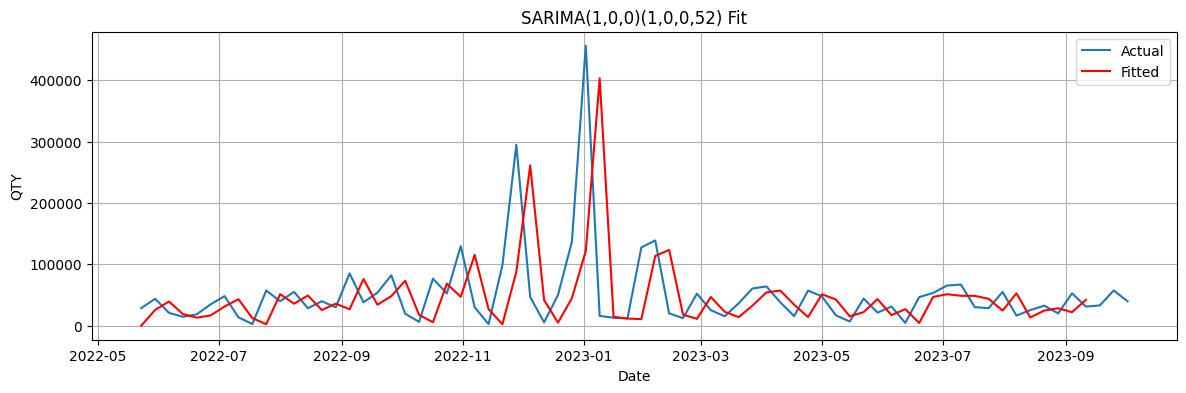

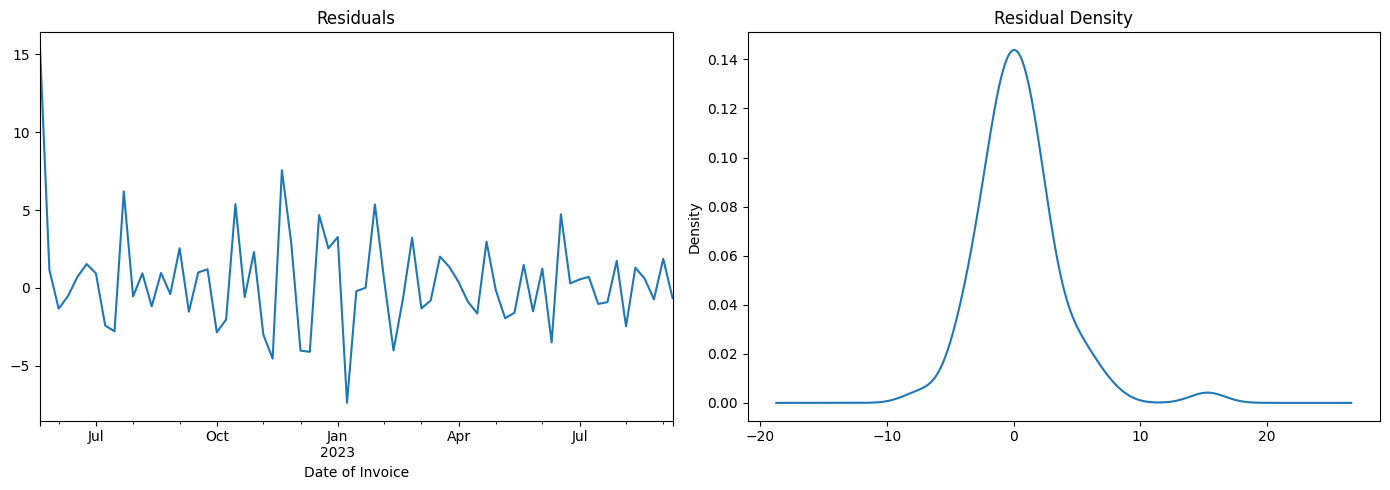

MAPE for the last 3 weeks: 34.10%
2023-10-09    16375.0
2023-10-16    22824.0
2023-10-23    19606.0
2023-10-30    21282.0
Freq: W-MON, Name: predicted_mean, dtype: float64


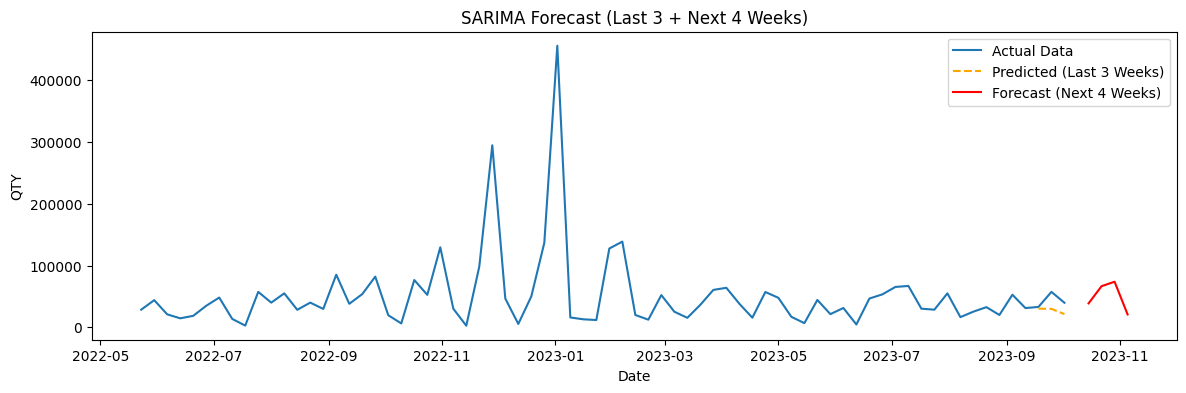

In [ ]:
#SARIMA
# Step 1: Split data (train and test)
train_data = df_weekly[:-3]  # All data except the last 3 weeks
test_data = df_weekly[-3:]   # Last 3 weeks

# Store fitted lambda used for boxcox
fitted_lambda = lmbda 

# Define SARIMA model (example: seasonal_order=(1, 0, 0, 52) for weekly seasonality)
model = SARIMAX(train_data['QTY_boxcox'],
                order=(1, 0, 0),
                seasonal_order=(1, 0, 0, 52),  # You can tweak this based on ACF/PACF or grid search
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# --- PLOT ACTUAL vs FITTED ---
plt.figure(figsize=(14, 4))
plt.plot(df_weekly.index, inv_boxcox(df_weekly['QTY_boxcox'], fitted_lambda), label='Actual')  # Inverse actual values
plt.plot(train_data.index, inv_boxcox(model_fit.fittedvalues, fitted_lambda), color='red', label='Fitted')# Inverse fitted values
plt.title('SARIMA(1,0,0)(1,0,0,52) Fit')
plt.xlabel('Date')
plt.ylabel('QTY')
plt.legend()
plt.grid(True)
plt.show()

# Plot residuals
residuals = model_fit.resid

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
residuals.plot(title="Residuals")

plt.subplot(1, 2, 2)
residuals.plot(kind='kde', title='Residual Density')

plt.tight_layout()
plt.show()

# Step 3: Predict the last 3 weeks
predicted_values_box = model_fit.forecast(steps=3)
actual_values_box = test_data['QTY_boxcox'].values

#inverse
predicted_values = inv_boxcox(predicted_values_box, fitted_lambda)
actual_values = inv_boxcox(actual_values_box, fitted_lambda)

# Step 4: Calculate MAPE for the last 3 weeks
mape = mean_absolute_percentage_error(actual_values, predicted_values)
print(f"MAPE for the last 3 weeks: {mape * 100:.2f}%")

# Step 5: Forecast the next 4 weeks (future forecast)
forecast_values = model_fit.forecast(steps=7)[-4:]  # last 4 from 7 to keep continuity
forecasted_values = inv_boxcox(forecast_values, fitted_lambda)
print(np.round(forecasted_values))

# Forecast dates for plotting
forecast_dates = pd.date_range(df_weekly.index[-1] + pd.Timedelta(weeks=1), periods=4, freq='W')

# Plotting the forecasted values
plt.figure(figsize=(14, 4))
plt.plot(df_weekly.index, inv_boxcox(df_weekly['QTY_boxcox'], fitted_lambda), label='Actual Data')
plt.plot(test_data.index, predicted_values, label='Predicted (Last 3 Weeks)', color='orange', linestyle='--')
plt.plot(forecast_dates, forecast_values_inv, label='Forecast (Next 4 Weeks)', color='red')
plt.title('SARIMA Forecast (Last 3 + Next 4 Weeks)')
plt.xlabel('Date')
plt.ylabel('QTY')
plt.legend()
plt.show()

